In [ ]:
#pip install KDEpy

In [1]:
import pandas as pd
import numpy as np
from KDEpy import FFTKDE
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from statsmodels.nonparametric.bandwidths import bw_silverman
import math

In [2]:
dax = pd.read_csv(r'data/DAX.csv')
dax.head()

# I will work with daily high
X = np.array(dax[['High']])

#set t as the time of estimation eg. last data point
t = len(X)

In [33]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X[:10])

In [3]:
# exponential weighing function
def weight(i,t,T, omega):
        w_i = (omega**(abs(t-i)) + omega**(2*T-t-i+1) + omega**(t+i-1))*(1-omega)/(1+omega)
        return w_i

# vectorizing the weights
weights = np.vectorize(weight)

def likelihood(omega,X):
    T = len(X)
    h = bw_silverman(X)
    sum_1 = 0
    for i in range(0,T):
            iterations = list(range(0,T)) #vector of i for weights
            w = weights(iterations, i, T,omega) #generating weights
            x, y = FFTKDE(kernel='gaussian', bw=h).fit(X, weights=w).evaluate(t) #density estimate at t
            y = y-(1/(math.sqrt(2*math.pi))*w[i-1]) # eliminating the term with i=t
            add = np.log((1/h)*sum(y)) 
            sum_1 = sum_1 + add
    l = -(1/T)*sum_1 #negative because changing max problem into min problem
    return l

In [4]:
def likelihood(omega,X,t):
    T = len(X)
    h = bw_silverman(X)
    iterations = list(range(0,T)) #vector of i for weights
    w = weights(iterations, t, T,omega) #generating weights
    x, y = FFTKDE(kernel='gaussian', bw=h).fit(X, weights=w).evaluate(t) #density estimate at t
    #y = y-(1/(math.sqrt(2*math.pi))*w[t-1]) # eliminating the term with i=t
    l   = -(1/T)*sum(np.log((y))) #negative because changing max problem into min problem
    return l

In [5]:
x0=np.array([0.1]) # initial guess
bounds = Bounds([0.00001],[1]) #bounds for omega #zero not included
omega_opt = minimize(likelihood,x0, method='trust-constr',args=(X,t), options={'disp': True}, bounds= bounds)

`gtol` termination condition is satisfied.
Number of iterations: 14, function evaluations: 20, CG iterations: 9, optimality: 7.35e-09, constraint violation: 0.00e+00, execution time: 0.083 s.


In [6]:
omega_opt

 barrier_parameter: 0.00016000000000000007
 barrier_tolerance: 0.00016000000000000007
          cg_niter: 9
      cg_stop_cond: 1
            constr: [array([0.99454505])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.08281922340393066
               fun: 4.42639995573164
              grad: array([-0.02892321])
               jac: [<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([7.35209711e-09])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 20
              nhev: 0
               nit: 14
             niter: 14
              njev: 0
        optimality: 7.352097108198619e-09
            status: 1
           success: True
         tr_radius: 6736.321372650127
                 v: [array([0.02892322])]
                 x: array([

In [7]:
omega_opt = omega_opt['x'] #extracting the value of optimal omega

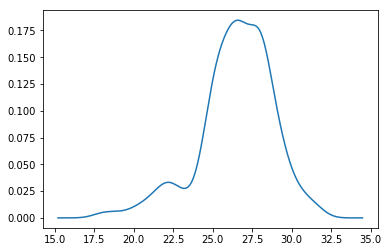

In [8]:
# Compute density estimates using 'silverman' bandwidth with uniform weights
x, y1 = FFTKDE(kernel='gaussian', bw='silverman').fit(X).evaluate(t)
plt.plot(x, y1, label='KDE /w silverman')

In [9]:
# Compute a weighted estimate on the same grid, using exponential weights
T = len(X)
iterations = list(range(0,T))
w = weights(iterations, t, T,omega_opt)
x,y2 = FFTKDE(kernel='gaussian', bw='silverman').fit(X, weights=w).evaluate(t)

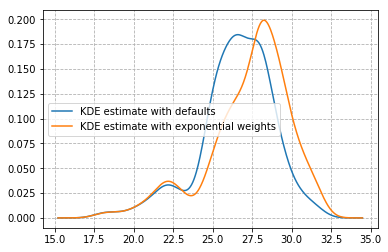

In [10]:
plt.plot(x, y1, label='KDE estimate with defaults')
plt.plot(x, y2, label='KDE estimate with exponential weights')
plt.grid(True, ls='--', zorder=-15); plt.legend()

### KDE estimate using sklearn

In [17]:
import pandas as pd
import numpy as np
from KDEpy import FFTKDE
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from statsmodels.nonparametric.bandwidths import bw_silverman
import math
from sklearn.neighbors import KernelDensity
import datetime as dt

In [11]:
dax = pd.read_csv(r'data/returns_dax.csv', index_col=[0])
nq = pd.read_csv(r'data/returns_nq.csv', index_col=[0])
dow = pd.read_csv(r'data/returns_dow.csv', index_col=[0])
crix = pd.read_csv(r'data/returns_crix.csv', index_col=[0])
crix.drop(crix.head(1).index,inplace = True)
snp500 = pd.read_csv(r'data/returns_snp500.csv', index_col=[0])
btc = pd.read_csv(r'data/returns_btc.csv', index_col=[0])
btc.drop(btc.head(1).index,inplace = True)
btc.drop(btc.tail(1).index,inplace = True)#btc has two additional data point

In [12]:
df = pd.read_csv(r'data/returns_dax.csv', index_col=[0])

# working with returns
# extracting only the rows with year 2019 and then later do the same for 2020
year = 2019
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'].dt.year == year]
X = np.array(df[['Low']])

#set t as the time of estimation eg. last data point
t = len(X)

In [13]:
### Creating X grid
values = np.array([value for value in range(1, t)])
values = values.reshape((len(values), 1))

In [14]:
# exponential weighing function
def weight(i,t,T, omega):
        w_i = (omega**(abs(t-i)) + omega**(2*T-t-i+1) + omega**(t+i-1))*(1-omega)/(1+omega)
        return w_i +0.000000000001

# vectorizing the weights
weights = np.vectorize(weight)

def likelihood(omega,X,t):
    T = len(X)
    h = bw_silverman(X)
    iterations = list(range(0,T)) #vector of i for weights
    w = weights(iterations, t, T,omega) #generating weights
    kde_weighted = KernelDensity(kernel='gaussian', bandwidth=h).fit(X, sample_weight=w)
    log_dens = kde_weighted.score_samples(values)
    #y = y-(1/(math.sqrt(2*math.pi))*w[t-1]) # eliminating the term with i=t
    l   = -(1/T)*sum(log_dens) #negative because changing max problem into min problem
    #print(omega)
    #print(l)
    return l

def optimize_manual(X,t):
    ## Manually calculating the optminum
    omega_grid = np.linspace(0.000000001,0.99999999,100).tolist()
    ls = []
    for i in range(len(omega_grid)):
        omega = omega_grid[i];
        l = likelihood(omega, X,t);
        ls.append(l);
    fun_val_opt= min(ls)
    print('optimal function value is:',fun_val_opt)
    omega_opt = omega_grid[ls.index(min(ls))]
    print('optimal omega is:',omega_opt)
    return omega_opt

In [15]:
T = len(X)
h = bw_silverman(X)
iterations = list(range(0,T)) #vector of i for weights
#w = weights(iterations, t, T,0.1) #generating weights

In [18]:
x0=np.array([0.5]) # initial guess
bounds = Bounds([0.0],[1.0]) #bounds for omega #zero not included
omega_opt = minimize(likelihood,x0, method='trust-constr',args=(X,t), options={'disp': True}, bounds= bounds)
omega_opt

/Users/izzy/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/izzy/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/izzy/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

`xtol` termination condition is satisfied.
Number of iterations: 99, function evaluations: 218, CG iterations: 87, optimality: 6.51e-06, constraint violation: 0.00e+00, execution time:  3.3 s.


/Users/izzy/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/izzy/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/Users/izzy/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 87
      cg_stop_cond: 2
            constr: [array([0.9741538])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 3.305583953857422
               fun: 183923.7826956979
              grad: array([0.00976562])
               jac: [<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([6.5148056e-06])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 218
              nhev: 0
               nit: 99
             niter: 99
              njev: 0
        optimality: 6.514805600104853e-06
            status: 2
           success: True
         tr_radius: 1.0000000000000005e-09
                 v: [array([-0.00975911])]
                 x: array

In [19]:
omega_opt = omega_opt['x'] #extracting the value of optimal omega
omega_opt

array([0.9741538])

In [20]:
## Manually calculating the optminum
omega_grid = np.linspace(0.001,0.96,100).tolist()
ls = []
for i in range(len(omega_grid)):
    omega = omega_grid[i];
    l = likelihood(omega, X,t);
    ls.append(l);
fun_val_opt= min(ls)
print('optimal function value is:',fun_val_opt)
omega_opt = omega_grid[ls.index(min(ls))]
print('optimal omega is:',omega_opt)

optimal function value is: 183923.89321263554
optimal omega is: 0.96


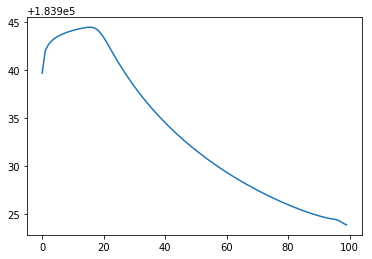

In [21]:
plt.plot(ls)

In [22]:
# Compute density estimates using 'silverman' bandwidth with no weights
h = bw_silverman(X)
print(h)
kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(X)
probabilities = np.exp(kde.score_samples(values))
sum(probabilities) #checking it sums to 1

[0.30619447]


0.991333654076182

In [23]:
# Compute a weighted estimate on the same grid, using exponential weights
T = len(X)
iterations = list(range(0,T))
w = weights(iterations, t, T,omega_opt)
kde_weighted = KernelDensity(kernel='gaussian', bandwidth=h).fit(X, sample_weight=w)
probabilities_weighted = np.exp(kde_weighted.score_samples(X))
sum(probabilities_weighted) #sum
print(np.trapz(probabilities_weighted.ravel(), X.ravel())) #integral

0.47479964637773064


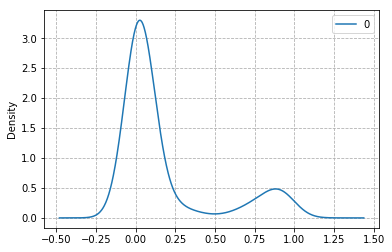

In [24]:
#plt.plot(X, probabilities, label='KDE estimate with no weights')
pd.DataFrame(probabilities_weighted).plot.kde()
plt.grid(True, ls='--', zorder=-15); plt.legend()

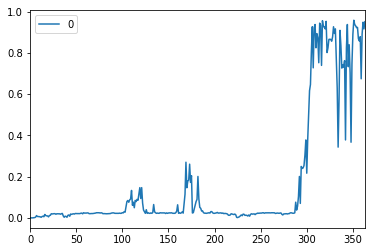

In [25]:
pd.DataFrame(probabilities_weighted).plot()


In [26]:
pd.DataFrame(probabilities_weighted).describe()

,0
count,364.000000
mean,0.171465
std,0.302324
min,0.000007
25%,0.020506
50%,0.023821
75%,0.086016
max,0.957960


### Summarized code

optimal function value is: 74.08641332524329
optimal omega is: 0.99999999
optimal function value is: 48.428920434801405
optimal omega is: 0.99999999


IndexError: too many indices for array

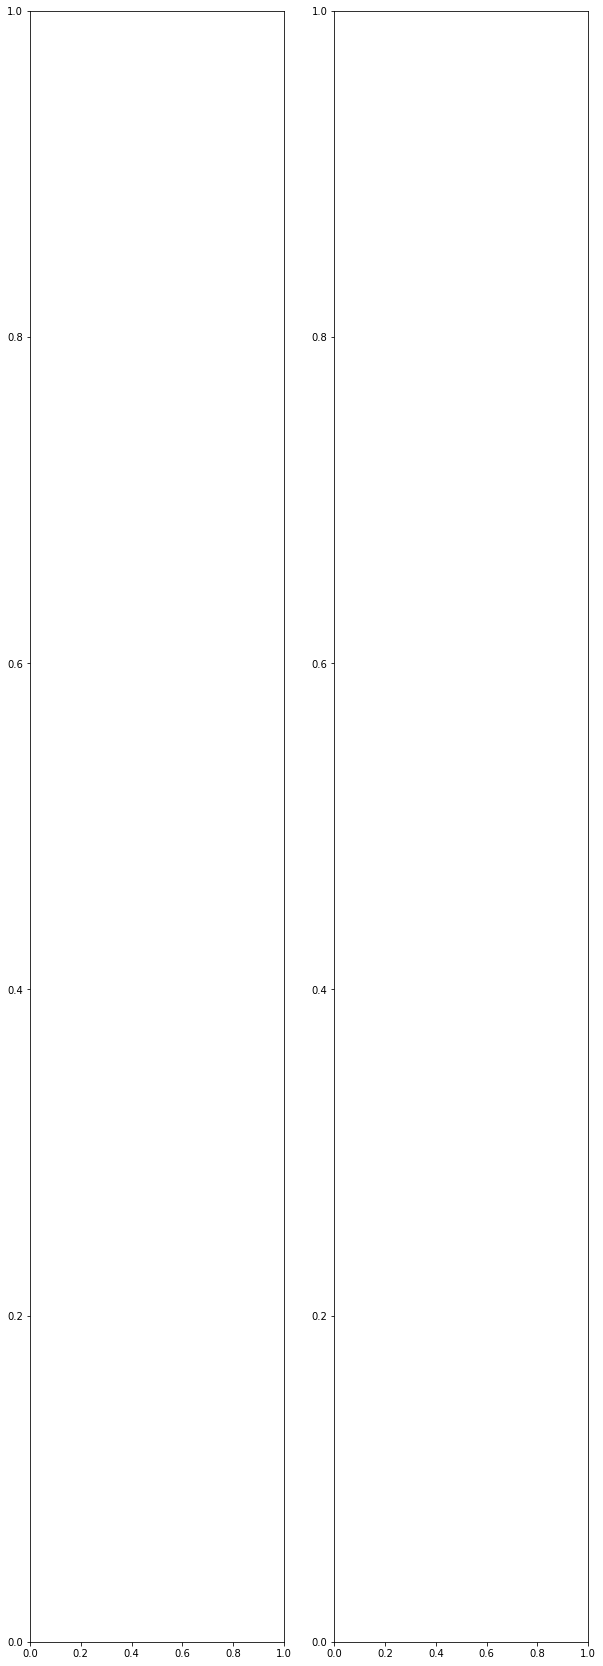

In [28]:
indices = [dax]#, nq, dow,btc, snp500]
#indices = [dax]
x0=np.array([0.5]) # initial guess
bounds = Bounds([0.0],[1.0]) #bounds for omega #zero not included
fig, axs = plt.subplots(len(indices), 2, figsize=(10, 30))
for i in range(len(indices)):
    probs = []
    values_list = []
    for year in [2019, 2020]:
        df = indices[i]
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[df['Date'].dt.year == year]
        X = np.array(df[['returns']])
        t = len(X)
        T = len(X)
        h = bw_silverman(X)
        iterations = list(range(0,T)) #vector of i for weights
        omega_opt = optimize_manual(X,t)
        #omega_opt = minimize(likelihood,x0, method='trust-constr',args=(X,t), bounds= bounds)
        #omega_opt = omega_opt['x']
        w = weights(iterations, t, T,omega_opt)
        kde_weighted = KernelDensity(kernel='gaussian', bandwidth=h).fit(X, sample_weight=w)
        #values = np.array([value for value in range(1, t)])
        #values = values.reshape((len(values), 1))
        values  = np.linspace(-4, 8, 2000)
        values = values[:, None]
        prob_weighted = np.exp(kde_weighted.score_samples(values))
        values_list.append(values)
        probs.append(prob_weighted)
    axs[i, 0].plot(values_list[0], probs[0], 'tab:red')
    axs[i, 0].set_title('KDE estimate for 31.12.2019')
    axs[i, 1].plot(values_list[1], probs[1], 'tab:green')
    axs[i, 1].set_title('KDE estimate for 31.12.2020')

In [46]:
## Garch model

#pip install arch
from arch import arch_model

residuals = pd.DataFrame()
indices = [dax, nq, dow,btc, snp500, crix]
columns = ['res_dax', 'res_nq', 'res_dow','res_btc', 'res_snp500', 'res_crix']


for i in range(len(indices)):
    df = indices[i]
    X = np.array(df[['returns']])
    # define model
    model = arch_model(X,  vol='GARCH', p=1, q=1)
    # residuals
    res = model.fit()
    # fetching residuals adding as a column to Dataframe
    residuals[columns[i]] = res.resid
residuals.to_csv('residuals.csv',index=False)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1094.9225268184318
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1091.0015042606599
Iteration:      3,   Func. Count:     27,   Neg. LLF: 1090.9938981703876
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1090.9648370184127
Iteration:      5,   Func. Count:     41,   Neg. LLF: 1090.6535134965848
Iteration:      6,   Func. Count:     48,   Neg. LLF: 1090.4346107657007
Iteration:      7,   Func. Count:     56,   Neg. LLF: 1090.357518948485
Iteration:      8,   Func. Count:     64,   Neg. LLF: 1090.3540394071508
Iteration:      9,   Func. Count:     70,   Neg. LLF: 1090.353633082621
Iteration:     10,   Func. Count:     76,   Neg. LLF: 1090.3536301524196
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1090.3536301524991
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1069.12